|Field|Description|
|---:|:---|
|Country|Country|
|Year|Year|
|Status|Developed or Developing status|
|Life expectancy|Life Expectancy in age|
|Adult Mortality|Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)|
|infant deaths|Number of Infant Deaths per 1000 population|
|Alcohol|Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)|
|percentage expenditure|Expenditure on health as a percene of Gross Domestic Product per capita(%)|
|Hepatitis B|Hepatitis B (HepB) immunization coverage among 1-year-olds (%)|
|Measles|Measles - number of reported cases per 1000 population|
|BMI|Average Body Mass Index of entire population|
|under-five deaths|Number of under-five deaths per 1000 population|
|Polio|Polio (Pol3) immunization coverage among 1-year-olds (%)|
|Total expenditure|General government expenditure on health as a percene of total government expenditure (%)|
|Diphtheria|Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)|
|HIV/AIDS|Deaths per 1 000 live births HIV/AIDS (0-4 years)|
|GDP|Gross Domestic Product per capita (in USD)|
|Population|Population of the country|
|thinness 1-19 years|Prevalence of thinness among children and adolescents for Age 10 to 19 (%)|
|thinness 5-9 years|Prevalence of thinness among children for Age 5 to 9(%)|
|Income composition of resources|Income composition of resources|
|Schooling|Number of years of Schooling(years)|


In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tools
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#ridge
from sklearn.linear_model import Ridge

In [148]:
df = pd.read_csv('Life Expectancy Data.csv')
df.head()
df['GDP_per_capita_log'] = np.log(df['GDP_per_capita']).replace([np.inf, -np.inf], np.nan).fillna(0)
df['GDP_per_capita_exp'] = np.exp(df['GDP_per_capita_log'])
df.drop(columns=['GDP_per_capita_log','GDP_per_capita_exp'] , inplace=True)


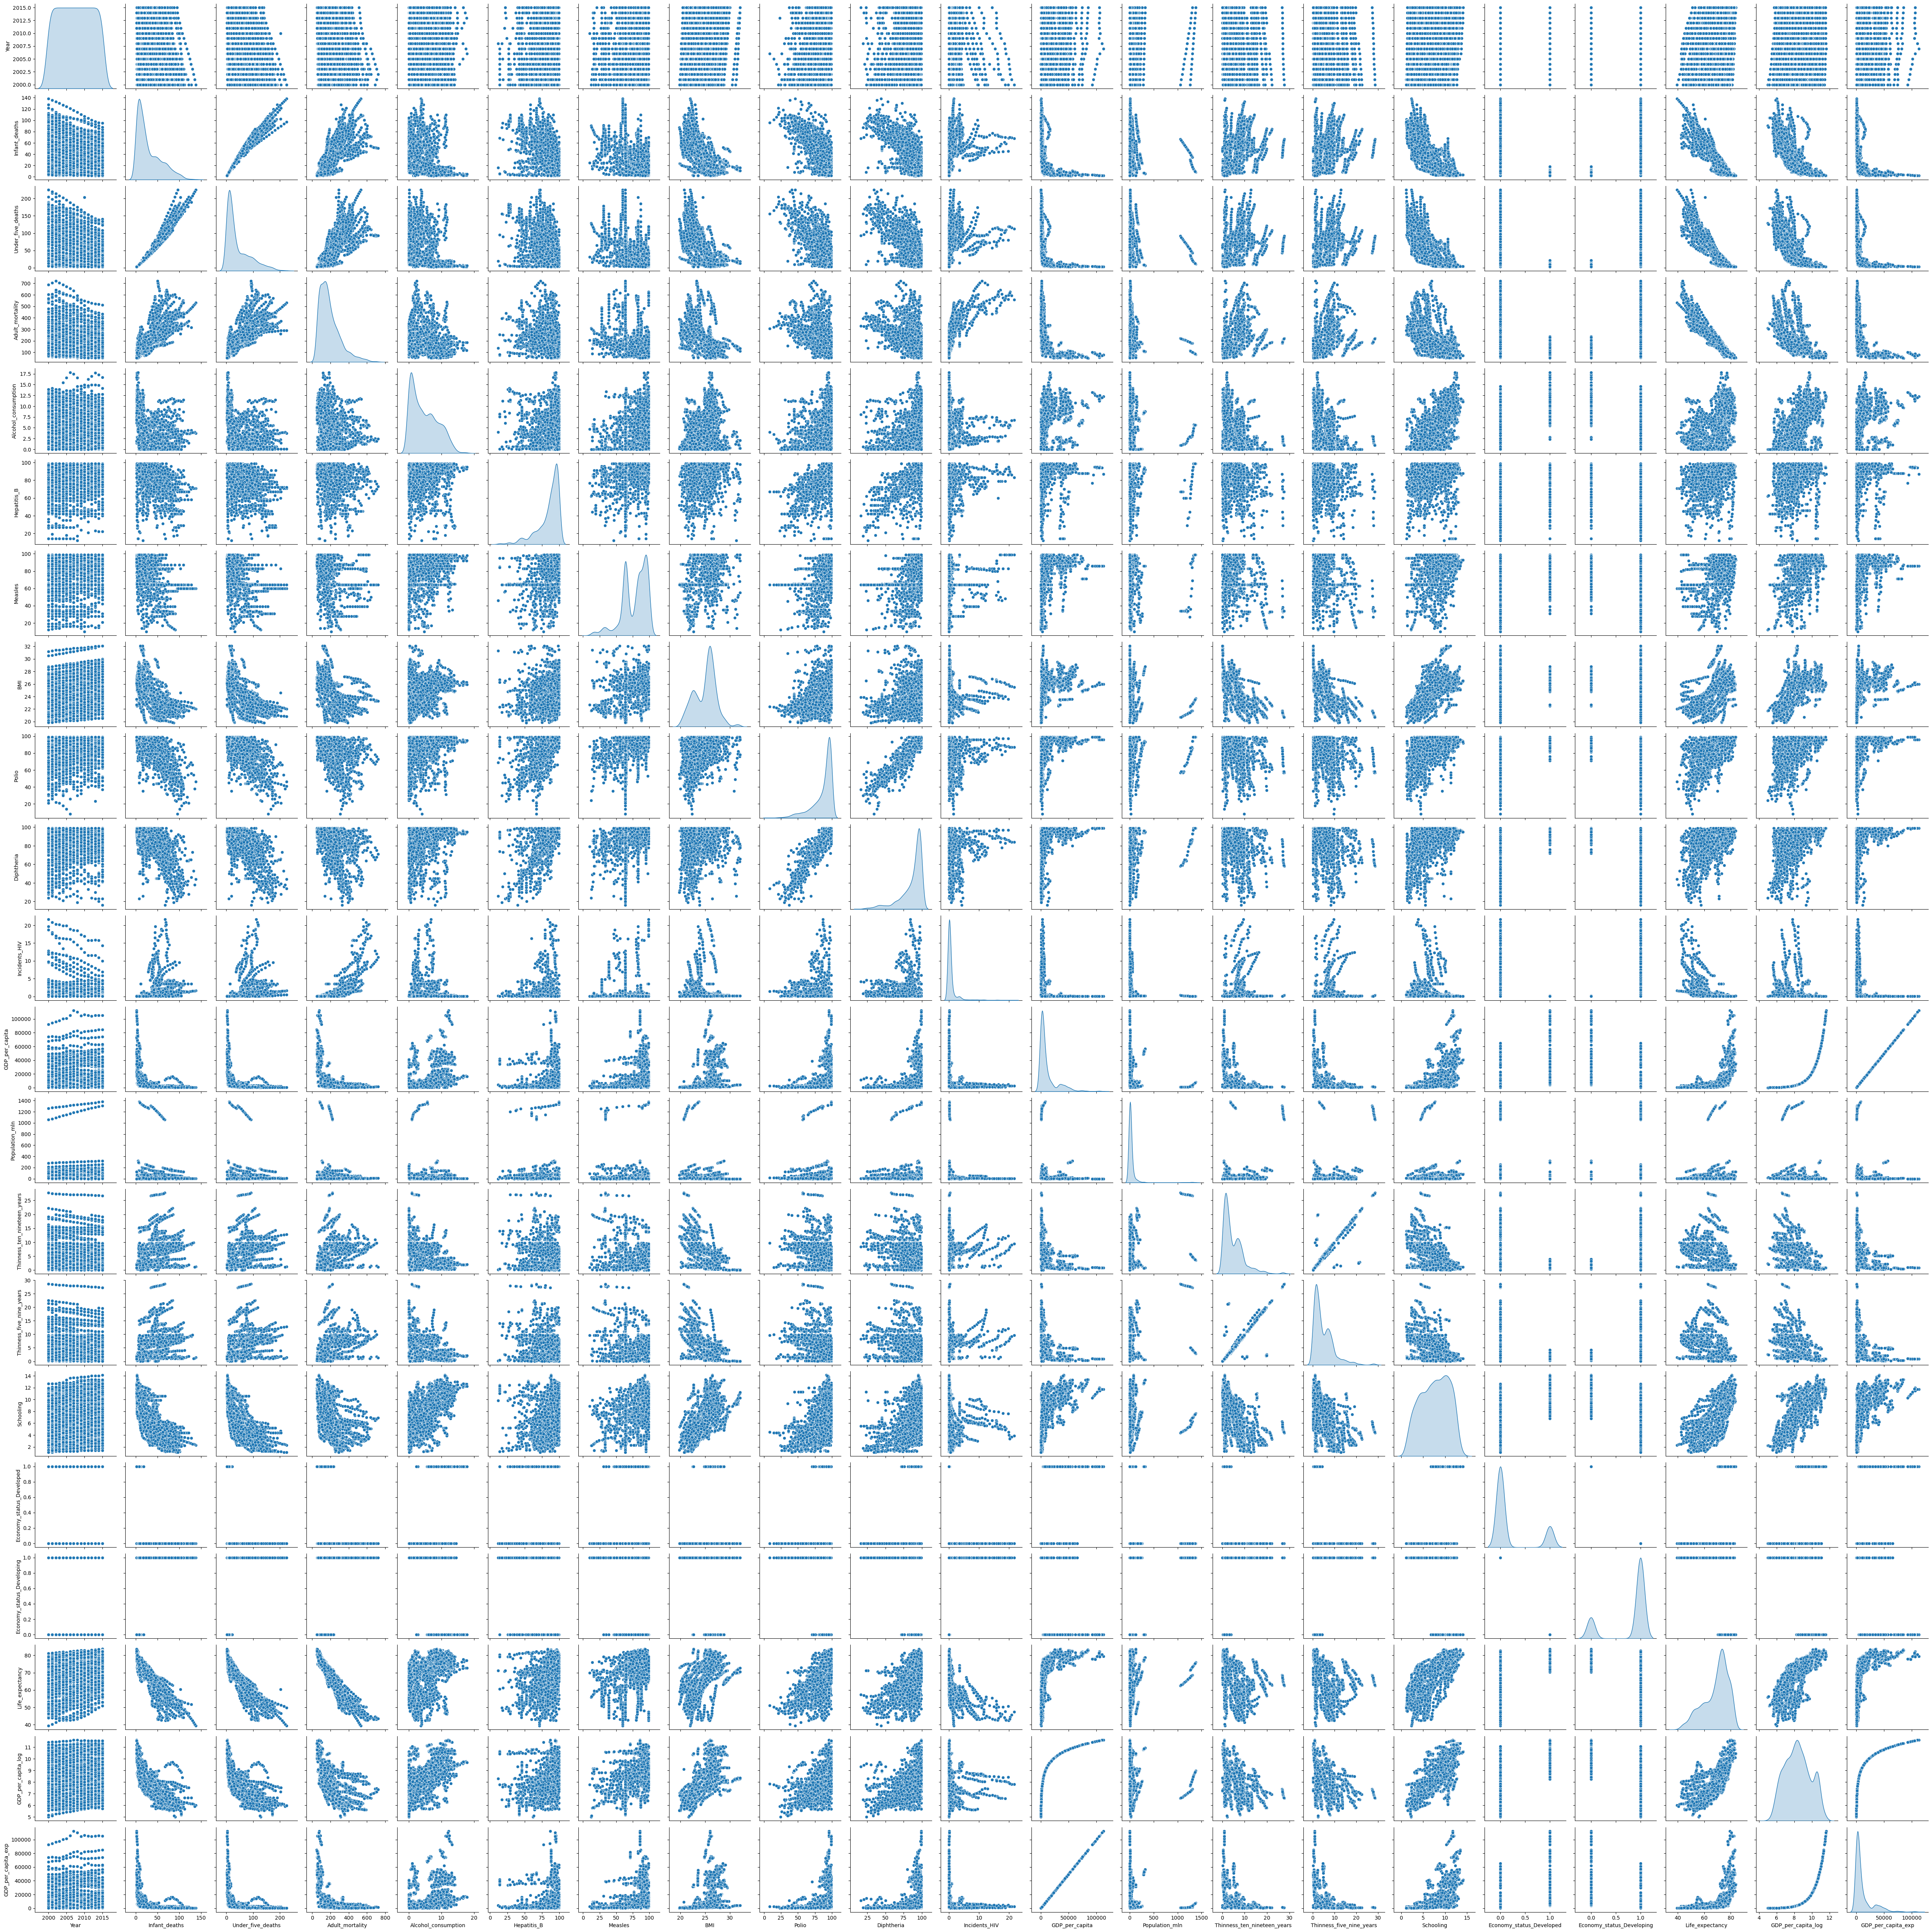

In [146]:
sns.pairplot(df, diag_kind='kde')

In [124]:
df.head()

Country          Region  Year  Infant_deaths  Under_five_deaths  \
0  Turkiye     Middle East  2015           11.1               13.0   
1    Spain  European Union  2015            2.7                3.3   
2    India            Asia  2007           51.5               67.9   
3   Guyana   South America  2006           32.8               40.5   
4   Israel     Middle East  2012            3.4                4.3   

   Adult_mortality  Alcohol_consumption  Hepatitis_B  Measles   BMI  ...  \
0         105.8240                 1.32           97       65  27.8  ...   
1          57.9025                10.35           97       94  26.0  ...   
2         201.0765                 1.57           60       35  21.2  ...   
3         222.1965                 5.68           93       74  25.3  ...   
4          57.9510                 2.89           97       89  27.0  ...   

   Diphtheria  Incidents_HIV  GDP_per_capita  Population_mln  \
0          97           0.08           11006           78.53   
1          97           0.09           25742           46.44   
2          64           0.13            1076         1183.21   
3          93           0.79            4146            0.75   
4          94           0.08           33995            7.91   

   Thinness_ten_nineteen_years  Thinness_five_nine_years  Schooling  \
0                          4.9                       4.8        7.8   
1                          0.6                       0.5        9.7   
2                         27.1                      28.0        5.0   
3                          5.7                       5.5        7.9   
4                          1.2                       1.1       12.8   

   Economy_status_Developed  Economy_status_Developing  Life_expectancy  
0                         0                          1             76.5  
1                         1                          0             82.8  
2                         0                          1             65.4  
3                         0                          1             67.0  
4                         1                          0             81.7  

[5 rows x 21 columns]

In [119]:
df.dtypes

Country                         object
Region                          object
Year                             int64
Infant_deaths                  float64
Under_five_deaths              float64
Adult_mortality                float64
Alcohol_consumption            float64
Hepatitis_B                      int64
Measles                          int64
BMI                            float64
Polio                            int64
Diphtheria                       int64
Incidents_HIV                  float64
GDP_per_capita                   int64
Population_mln                 float64
Thinness_ten_nineteen_years    float64
Thinness_five_nine_years       float64
Schooling                      float64
Economy_status_Developed         int64
Economy_status_Developing        int64
Life_expectancy                float64
dtype: object

In [201]:
def feature_eng(df):
    df.drop(columns=['Economy_status_Developing', 'Region', 'Country'], inplace=True)
    df['Year'] = df['Year'] % 2000

    df['Adult_mortality_percentage'] = df['Adult_mortality'] / 100
    df.drop(columns=['Adult_mortality'], inplace=True)
    df['infant_mortality_percentage'] = df['Infant_deaths'] / 100
    df['Under_5_mortality_percentage'] = df['Under_five_deaths'] / 100
    df['Measles_percentage'] = df['Measles'] / 100
    df['HIV_AIDS_percentage'] = df['Incidents_HIV'] / 100
    #df.drop(columns=['Adult_mortality', 'Infant_deaths', 'Under_five_deaths', 'Measles', 'Incidents_HIV'], inplace=True)
    df['GDP_per_capita_log'] = np.log(df['GDP_per_capita']).replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

In [202]:
def stepwise_selection(X, y, threshold_in = 0.01, threshold_out = 0.05, verbose = True):
    # The function is checking for p-values (whether features are statistically significant) - lower is better
    included = [] # this is going to be the list of features we keep
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = 'float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        # we add the feature with the lowest (best) p-value under the threshold to our 'included' list
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) # specifying the verbose text


        # backward step: removing features if new features added to the list make them statistically insignificant
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        # if the p-value exceeds the upper threshold, the feature will be dropped from the 'included' list
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
def create_ft(df):
    features = df.drop(columns=['Life_expectancy'])
    features = feature_eng(features)
    target = df['Life_expectancy']
    stepwiseCols = stepwise_selection(features, target, threshold_in=0.01, threshold_out=0.05, verbose=True)
    features = features[stepwiseCols]
    return features, target, stepwiseCols


features, target, stepwiseCols = create_ft(df)

# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # newModel = Ridge(alpha=0.1)
# # newModel.fit(X_train_scaled, y_train)

# # predictions = newModel.predict(X_test_scaled)
# # results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
# # rmse = statsmodels.tools.eval_measures.rmse(y_test, predictions)
# # print(f'Root Mean Squared Error: {rmse:.5f}')

# # # r^2 

# # r_squared = newModel.score(X_test_scaled, y_test)
# # print(f'R^2: {r_squared:.5f}')


# X_train_scaled = sm.add_constant(X_train)
# X_test_scaled = sm.add_constant(X_test)
# model = sm.OLS(y_train, X_train_scaled).fit()
# predictions = model.predict(X_test_scaled)
# results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# rmse = statsmodels.tools.eval_measures.rmse(y_test, predictions)
# print(f'Root Mean Squared Error: {rmse:.5f}') 

# allow the user to enter data for prediction

# def predict_life_expectancy(input_data):
#     input_df = pd.DataFrame([input_data])
#     input_df = feature_eng(input_df)
#     input_df = input_df[stepwiseCols]  # ensure same column order
#     input_df = sm.add_constant(input_df, has_constant='add') 
#     prediction = model.predict(input_df)
#     return prediction[0]

# def take_user_input():
#     input_data = {}
#     for col in df.columns:
#         if col in ['Year', 'GDP_per_capita', 'Population_mln']:
#             value = float(input(f"Enter {col} (numeric): "))
#         else:
#             value = float(input(f"Enter {col} (numeric): "))
#         input_data[col] = value
#     return input_data


# sample_input_data = { 
#     'Year': 2015,
#     'Infant_deaths': 11.2,
#     'Under_five_deaths': 13,
#     'Adult_mortality': 106,
#     'Alcohol_consumption': 
#     1.3,
#     'Hepatitis_B': 97,
#     'Measles': 65,
#     'BMI': 28,
#     'Polio': 97,
#     'Diphtheria': 97,
#     'Incidents_HIV': 0.08,
#     'GDP_per_capita': 11006,
#     'Population_mln': 78.5, 
#     'Thinness_ten_nineteen_years': 5,
#     'Thinness_five_nine_years': 4.8,
#     'Schooling': 7.8,
#     'Economy_status_Developed': 0, 
#     'Economy_status_Developing': 1
#     }

# input_data = take_user_input()



# predicted_life_expectancy = predict_life_expectancy(input_data)
# print(f'Predicted Life Expectancy: {predicted_life_expectancy:.2f} years')

# model.summary()

Add  Adult_mortality_percentage     with p-value 0.0
Add  Under_five_deaths              with p-value 0.0
Add  Under_5_mortality_percentage   with p-value 0.0
Add  Economy_status_Developed       with p-value 5.67996e-179
Add  GDP_per_capita_log             with p-value 5.05581e-64
Add  BMI                            with p-value 7.63373e-16
Add  infant_mortality_percentage    with p-value 3.40708e-15
Add  Infant_deaths                  with p-value 3.40708e-15
Add  Schooling                      with p-value 2.65173e-13
Add  Thinness_ten_nineteen_years    with p-value 3.99653e-07
Add  Year                           with p-value 1.27494e-06
Add  Alcohol_consumption            with p-value 0.000125025
Add  HIV_AIDS_percentage            with p-value 0.00190403
Add  Hepatitis_B                    with p-value 0.00150559
Add  Incidents_HIV                  with p-value 0.000713798
Add  Polio                          with p-value 0.00231549


In [ ]:
def train_model(features, target):
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # newModel = Ridge(alpha=0.1)
    # newModel.fit(X_train_scaled, y_train)

    # predictions = newModel.predict(X_test_scaled)
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    # rmse = statsmodels.tools.eval_measures.rmse(y_test, predictions)
    # print(f'Root Mean Squared Error: {rmse:.5f}')

    # # r^2 

    # r_squared = newModel.score(X_test_scaled, y_test)
    # print(f'R^2: {r_squared:.5f}')

    X_train_scaled = sm.add_constant(X_train)
    X_test_scaled = sm.add_constant(X_test)
    model = sm.OLS(y_train, X_train_scaled).fit()

    train_rmse = statsmodels.tools.eval_measures.rmse(y_train, model.predict(X_train_scaled))
    train_mae = statsmodels.tools.eval_measures.meanabs(y_train, model.predict(X_train_scaled))
    print(f'Train Root Mean Squared Error: {train_rmse:.5f}')
    print(f'Train Mean Absolute Error: {train_mae:.5f}')

    return model, X_train_scaled, X_test_scaled, y_test

def evaluate_model(model, X_train_scaled, X_test_scaled, y_test):
    predictions = model.predict(X_test_scaled)
    results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

    rmse = statsmodels.tools.eval_measures.rmse(y_test, predictions)
    mae = statsmodels.tools.eval_measures.meanabs(y_test, predictions)
    vare = statsmodels.tools.eval_measures.vare(y_test, predictions)
    print(f'Root Mean Squared Error: {rmse:.5f}') 
    print(f'Mean Absolute Error: {mae:.5f}')
    print(f'Variance Explained: {vare:.5f}')

model, X_train_scaled, X_test_scaled, y_test = train_model(features, target)
evaluate_model(model, X_train_scaled, X_test_scaled, y_test)

Train Root Mean Squared Error: 1.33590
Train Mean Absolute Error: 1.06028
Root Mean Squared Error: 1.34961
Mean Absolute Error: 1.08907
Variance Explained: 1.81875


In [205]:
def predict_life_expectancy(input_data):
    input_df = pd.DataFrame([input_data])
    input_df = feature_eng(input_df)
    input_df = input_df[stepwiseCols]  # ensure same column order
    input_df = sm.add_constant(input_df, has_constant='add') 
    prediction = model.predict(input_df)
    return prediction[0]

def take_user_input():
    input_data = {}
    for col in df.columns:
        if col in ['Life_expectancy']:
            pass
        if col in ['Region', 'Country']:
            value = str(input(f"Enter {col} (numeric): "))
        else:
            value = float(input(f"Enter {col} (numeric): "))
        input_data[col] = value
    return input_data


# # Example input data
# sample_input_data = { 
#     'Year': 2015,
#     'Infant_deaths': 11.2,
#     'Under_five_deaths': 13,
#     'Adult_mortality': 106,
#     'Alcohol_consumption': 
#     1.3,
#     'Hepatitis_B': 97,
#     'Measles': 65,
#     'BMI': 28,
#     'Polio': 97,
#     'Diphtheria': 97,
#     'Incidents_HIV': 0.08,
#     'GDP_per_capita': 11006,
#     'Population_mln': 78.5, 
#     'Thinness_ten_nineteen_years': 5,
#     'Thinness_five_nine_years': 4.8,
#     'Schooling': 7.8,
#     'Economy_status_Developed': 0, 
#     'Economy_status_Developing': 1
#     }



input_data = take_user_input()



predicted_life_expectancy = predict_life_expectancy(input_data)
print(f'Predicted Life Expectancy: {predicted_life_expectancy:.2f} years')

# model.summary()

ValueError: could not convert string to float: ''

In [210]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X_train_scaled)
vif_data

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variable         VIF
0                          const  675.053717
1     Adult_mortality_percentage    8.334180
2              Under_five_deaths         inf
3   Under_5_mortality_percentage         inf
4       Economy_status_Developed    2.753713
5             GDP_per_capita_log    5.126240
6                            BMI    2.776837
7    infant_mortality_percentage         inf
8                  Infant_deaths         inf
9                      Schooling    4.395716
10   Thinness_ten_nineteen_years    1.943154
11                          Year    1.088183
12           Alcohol_consumption    2.440434
13           HIV_AIDS_percentage         inf
14                   Hepatitis_B    2.227585
15                 Incidents_HIV         inf
16                         Polio    3.782657

In [53]:
df.columns

Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
       'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
       'Economy_status_Developing', 'Life_expectancy'],
      dtype='object')

In [ ]:
medical_columns = ['Measles', 'Incidents_HIV', 'Hepatitis_B', 'Diphtheria', 'Polio']
